In [42]:
# data analysis
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pyampute.exploration.md_patterns import mdPatterns
from pyampute.exploration.mcar_statistical_tests import MCARTest
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Identify/Handle Duplicted Values

In [2]:
credit_risk_dataset = pd.read_csv(
    filepath_or_buffer = "../data/interim/credit_risk_dataset_prepped.csv"
)

In [3]:
credit_risk_dataset.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
32569    False
32570    False
32571    False
32572    False
32573    False
Length: 32574, dtype: bool

In [12]:
credit_risk_dataset[credit_risk_dataset.duplicated()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15969,23,42000,RENT,5.0,VENTURE,B,6000,9.99,False,0.14,False,4
15983,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,False,0.09,False,3
15989,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,False,0.08,False,4
16019,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,True,0.30,False,3
16022,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,False,0.15,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32004,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,False,0.06,False,12
32041,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,False,0.08,False,17
32166,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,False,0.10,False,12
32253,39,40000,OWN,4.0,VENTURE,B,1000,10.37,False,0.03,False,16


In [13]:
print("Credit Risk Dataset size prior to handling duplicated values:", credit_risk_dataset.shape)

Credit Risk Dataset size prior to handling duplicated values: (32574, 12)


In [14]:
credit_risk_dataset.drop_duplicates(
    keep='first',
    inplace=True
)

In [15]:
print("Credit Risk Dataset size post handling duplicated values:", credit_risk_dataset.shape)

Credit Risk Dataset size post handling duplicated values: (32409, 12)


### Missing Values

#### Re-Identifying Missing Values

In [17]:
credit_risk_dataset.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3094
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [18]:
credit_risk_dataset.isna().sum()/len(credit_risk_dataset)

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027369
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095467
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

##### Features that contain NaNs are missing only less than 10% of their total data - no cause for dropping columns (albeit this step would have been performed in the EDA section)

In [19]:
credit_risk_dataset.isna().all(axis=1).sum()

0

In [20]:
credit_risk_dataset.isna().all(axis=0).sum()

0

##### There aren't any completely empty row or columns

### Missing Value Validations

#### MCAR

##### Identifying Missing Value Patterns

In [21]:
nan_dataset = credit_risk_dataset[["person_emp_length", "loan_int_rate"]]

In [22]:
mdp = mdPatterns()

c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\pyampute\exploration\md_patterns.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group_values = group_values.append(colsums, ignore_index=True)


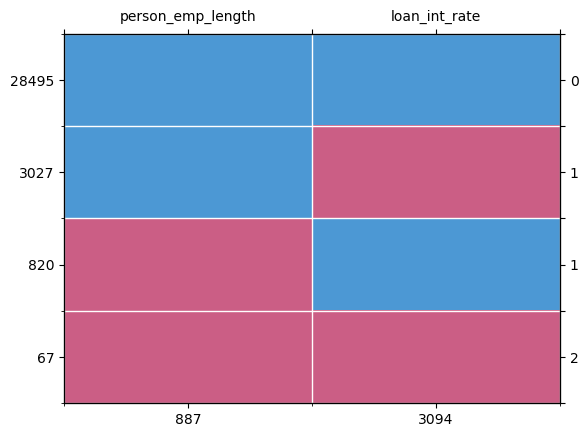

In [23]:
patterns = mdp.get_patterns(nan_dataset)

### MCAR Testing
##### * Null Hypothesis: Data is MCAR
##### * Alternative Hypothesis: Data is not MCAR

#### Numeric Observed

##### Little Test

In [29]:
mt_little = MCARTest(method="little")

In [30]:
numeric_dataset = credit_risk_dataset.select_dtypes(
    include=['int64', 'float64']
)

In [34]:
p_value = mt_little.little_mcar_test(
    X=numeric_dataset)
print(F"Little MCAR P value test: {p_value}")
if p_value <= 0.05:
    print(f"Reject H0 MCAR. Y missingness is dependent on X observed values.")
else:
    print(f"Fail to Reject H0 MCAR. Y missingness isn't dependent on X observed values.")

Little MCAR P value test: 0.0
Reject H0 MCAR. Y missingness is dependent on X observed values.


##### Reject the Null Hypothesis - The test determined the data is not MCAR; Its either MAR or MNAR.

#### T-Test

In [5]:
credit_risk_dataset['pel_missing'] = credit_risk_dataset['person_emp_length'].isnull()

In [6]:
credit_risk_dataset['lir_missing'] = credit_risk_dataset['loan_int_rate'].isnull()

In [9]:
credit_risk_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32574 entries, 0 to 32573
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   person_emp_length           31679 non-null  float64
 4   loan_intent                 32574 non-null  object 
 5   loan_grade                  32574 non-null  object 
 6   loan_amnt                   32574 non-null  int64  
 7   loan_int_rate               29459 non-null  float64
 8   loan_status                 32574 non-null  bool   
 9   loan_percent_income         32574 non-null  float64
 10  cb_person_default_on_file   32574 non-null  bool   
 11  cb_person_cred_hist_length  32574 non-null  int64  
 12  pel_missing                 32574 non-null  bool   
 13  lir_missing                 325

In [12]:
numeric_features = credit_risk_dataset.select_dtypes(
    include = ['int64', 'float64']
).drop(labels=['person_emp_length', 'loan_int_rate'],
       axis=1
)

In [16]:
dummy_indicators = credit_risk_dataset[["pel_missing", "lir_missing"]]

In [ ]:
pel_h0_rejection_count = 0
lir_h0_rejection_count = 0
pel_h0_fail_rejection_count = 0
lir_h0_fail_rejection_count = 0
for numeric_feature in numeric_features:
    for dummy_indicator in dummy_indicators:
        observed_group = credit_risk_dataset.loc[credit_risk_dataset[dummy_indicator] == 0, numeric_feature]
        missing_group = credit_risk_dataset.loc[credit_risk_dataset[dummy_indicator] == 1, numeric_feature]
        t_stat, p_value_ttest = stats.ttest_ind(observed_group,
                         missing_group,
                         equal_var=False)
        print(f"t-test for {numeric_feature} and {dummy_indicator}")
        print(f"P value {p_value_ttest:.4f}")
        if p_value_ttest <= 0.05:
            print("Conclusion: Reject H0 MCAR - Missingness of Y depends on X.")
            rejected += 1
            if dummy_indicator == "pel_missing":
                pel_h0_rejection_count += 1
            else:
                lir_h0_rejection_count += 1
        else:
            print("Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.")
            not_rejected += 1
            if dummy_indicator == "pel_missing":
                pel_h0_fail_rejection_count += 1
            else:
                lir_h0_fail_rejection_count += 1
print(f"Number of times H0 was rejected because it was PEL:{pel_h0_rejection_count}")
print(f"Number of times H0 was rejected because it was LIR: {lir_h0_rejection_count}")
print(f"Number of times H0 was failed rejected because it was PEL:{pel_h0_fail_rejection_count}")
print(f"Number of times H0 was failed rejected because it was LIR: {lir_h0_fail_rejection_count}")

t-test for person_age and pel_missing
P value 0.0259
Conclusion: Reject H0 MCAR - Missingness of Y depends on X.
t-test for person_age and lir_missing
P value 0.1185
Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.
t-test for person_income and pel_missing
P value 0.0000
Conclusion: Reject H0 MCAR - Missingness of Y depends on X.
t-test for person_income and lir_missing
P value 0.5018
Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.
t-test for loan_amnt and pel_missing
P value 0.0000
Conclusion: Reject H0 MCAR - Missingness of Y depends on X.
t-test for loan_amnt and lir_missing
P value 0.7004
Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.
t-test for loan_percent_income and pel_missing
P value 0.0000
Conclusion: Reject H0 MCAR - Missingness of Y depends on X.
t-test for loan_percent_income and lir_missing
P value 0.6348
Conclusion: Fail to Reject H0 MCAR - Missingness of Y doesn't depend on X.
t-test for cb_

##### It appears that PEL is MAR, but LIR is MCAR - So, people appear to be refusing to enter their employment length due to other variables in the dataset; whereas, the loan interest rates are randomly missing.

#### Logistic Regression

In [43]:
dir(smf)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'conditional_logit',
 'conditional_mnlogit',
 'conditional_poisson',
 'gee',
 'glm',
 'glmgam',
 'gls',
 'glsar',
 'logit',
 'mixedlm',
 'mnlogit',
 'negativebinomial',
 'nominal_gee',
 'ols',
 'ordinal_gee',
 'phreg',
 'poisson',
 'probit',
 'quantreg',
 'rlm',
 'wls']

In [ ]:
credit_risk_dataset['pel_missing'] = credit_risk_dataset['pel_missing'].astype(int)

In [57]:
credit_risk_dataset["lir_missing"] = credit_risk_dataset["lir_missing"].astype(int)

In [85]:
pred_df = credit_risk_dataset.select_dtypes(include=['int64', 'float64', 'int32']).drop(labels=['pel_missing', 'lir_missing'], axis=1).columns
pred_df

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

In [96]:
smf.logit(
    formula = "pel_missing ~ person_age + person_income + loan_amnt + loan_int_rate + loan_percent_income + cb_person_cred_hist_length",
    data = credit_risk_dataset
).fit(disp=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            pel_missing   No. Observations:                29459
Model:                          Logit   Df Residuals:                    29452
Method:                           MLE   Df Model:                            6
Date:                Fri, 12 Dec 2025   Pseudo R-squ.:                 0.06822
Time:                        21:03:47   Log-Likelihood:                -3512.9
converged:                       True   LL-Null:                       -3770.1
Covariance Type:            nonrobust   LLR p-value:                6.549e-108
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.6663      0.308     -5.408      0.000      -2.270      -1.062
person_age                    -0.0040      0.012     -0.326      0.744      -0.028       0.020
person_income              -9.254e-06    2.4e-06     -3.861      0.000    -1.4e-05   -4.56e-06
loan_amnt                     -0.0001   1.51e-05     -8.615      0.000      -0.000      -0.000
loan_int_rate                 -0.1011      0.012     -8.605      0.000      -0.124      -0.078
loan_percent_income            4.4722      0.579      7.728      0.000       3.338       5.606
cb_person_cred_hist_length     0.0076      0.019      0.406      0.684      -0.029       0.045
==============================================================================================
"""

In [99]:
pel_missing = credit_risk_dataset.pel_missing

In [100]:
lir_missing = credit_risk_dataset.lir_missing

In [86]:
smf.logit(
    formula = "pel_missing ~ " + " + ".join(pred_df),
    data = credit_risk_dataset
).fit(disp=False).summary()

c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\billy\anaconda3\envs\credit_risk_modeling\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, paramete

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            pel_missing   No. Observations:                28632
Model:                          Logit   Df Residuals:                    28624
Method:                           MLE   Df Model:                            7
Date:                Fri, 12 Dec 2025   Pseudo R-squ.:                     inf
Time:                        20:49:55   Log-Likelihood:            -1.7813e-08
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -14.6321   2.65e+05  -5.53e-05      1.000   -5.19e+05    5.19e+05
person_age                    -0.4014   1.15e+04  -3.49e-05      1.000   -2.25e+04    2.25e+04
person_income               1.171e-05      0.124   9.45e-05      1.000      -0.243       0.243
person_emp_length             -0.1087   5705.282  -1.91e-05      1.000   -1.12e+04    1.12e+04
loan_amnt                     -0.0012     24.909  -4.74e-05      1.000     -48.823      48.820
loan_int_rate                 -0.3051   1.02e+04     -3e-05      1.000   -1.99e+04    1.99e+04
loan_percent_income            0.6649   6.66e+05   9.98e-07      1.000   -1.31e+06    1.31e+06
cb_person_cred_hist_length     0.2255   1.73e+04    1.3e-05      1.000    -3.4e+04     3.4e+04
==============================================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

### MAR Identification

In [28]:
numeric_features = credit_risk_dataset.select_dtypes(
    include=['int64', 'float64']).columns
numeric_features

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

Text(0.5, 1.0, 'Missingness of PEL related to Personal Income')

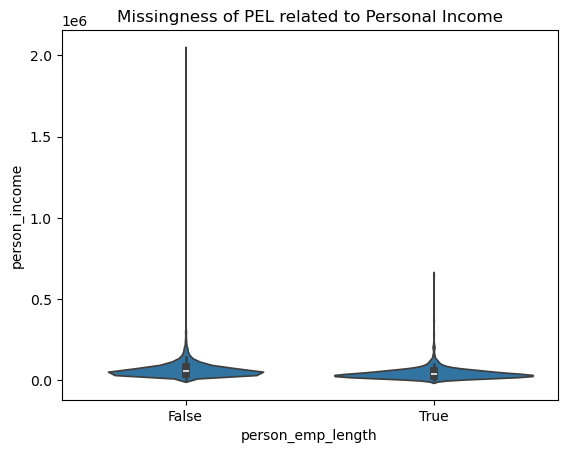

In [29]:
sns.violinplot(
        x=credit_risk_dataset['person_emp_length'].isnull(),
        y="person_income",
        data=credit_risk_dataset
    )
plt.title("Missingness of PEL related to Personal Income")

Text(0.5, 1.0, 'Missingness of PEL related to Loan Amount')

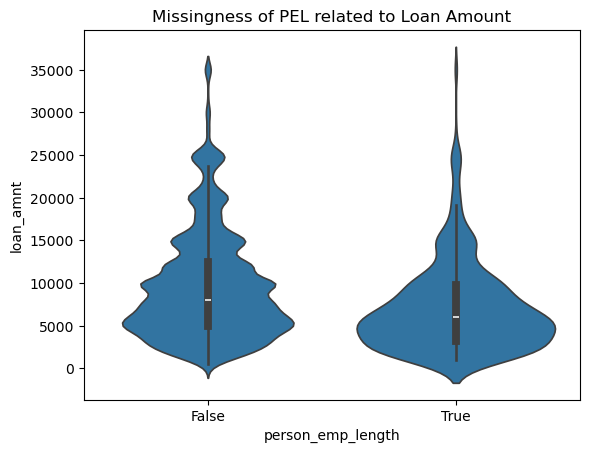

In [30]:
sns.violinplot(
        x=credit_risk_dataset['person_emp_length'].isnull(),
        y="loan_amnt",
        data=credit_risk_dataset
    )
plt.title("Missingness of PEL related to Loan Amount")

Text(0.5, 1.0, 'Missingness of LIR related to Personal Income')

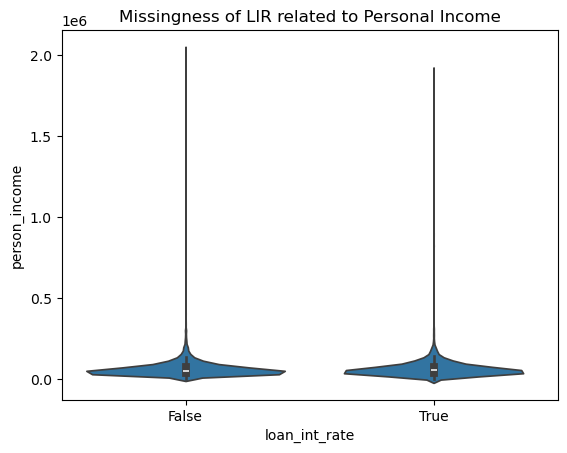

In [31]:
sns.violinplot(
        x=credit_risk_dataset.loan_int_rate.isnull(),
        y="person_income",
        data=credit_risk_dataset
    )
plt.title("Missingness of LIR related to Personal Income")

Text(0.5, 1.0, 'Missingness of LIR related to Personal Income')

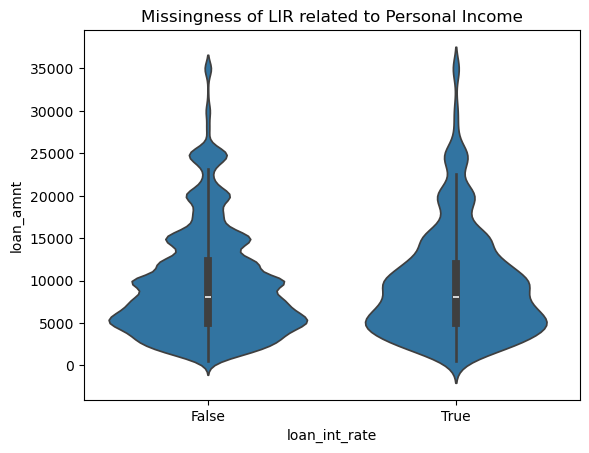

In [32]:
sns.violinplot(
        x=credit_risk_dataset.loan_int_rate.isnull(),
        y="loan_amnt",
        data=credit_risk_dataset
    )
plt.title("Missingness of LIR related to Personal Income")

#### The distributions appear to be similar, which would indicate that MAR is not at play; therefore MNAR is the probable cause for missing data - They either didn't want to put their employment length due to it being short or they didn't want to put their interest rate due to it being too high.